## Fake News Detection with Python

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Importing Data sets

In [4]:
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

In [5]:
#fake_news data 
fake_news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [6]:
#real_news data 
real_news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [7]:
real_news.shape,fake_news.shape

((21417, 4), (23481, 4))

In [8]:
fake_news['category']=0
real_news['category']=1

In [9]:
# Removing data
for i in range(23470,23481,1):
    fake_news.drop([i],axis=0,inplace=True)

for i in range(23406,23417,1):
    fake_news.drop([i],axis=0,inplace=True)
    

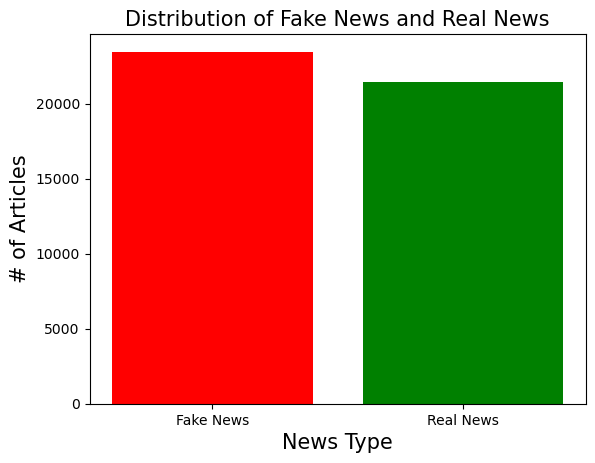

In [10]:
plt.bar('Fake News', len(fake_news), color='red')
plt.bar('Real News', len(real_news), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of Articles', size=15)
plt.show()

In [11]:
print('Difference in news articles:',len(fake_news)-len(real_news))

Difference in news articles: 2042


News subject count for fake news

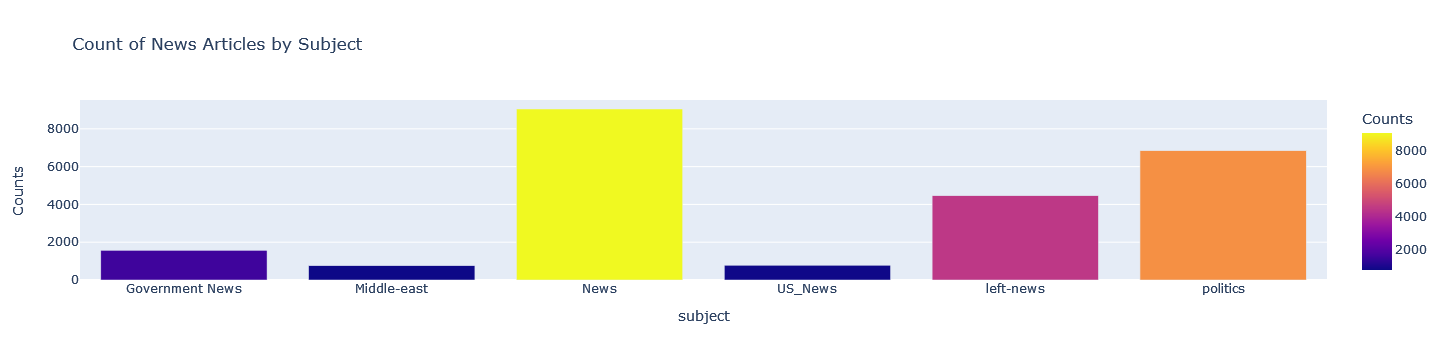

<Figure size 640x480 with 0 Axes>

In [12]:
plt.clf()
sub_check=fake_news.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

News subject count for real news

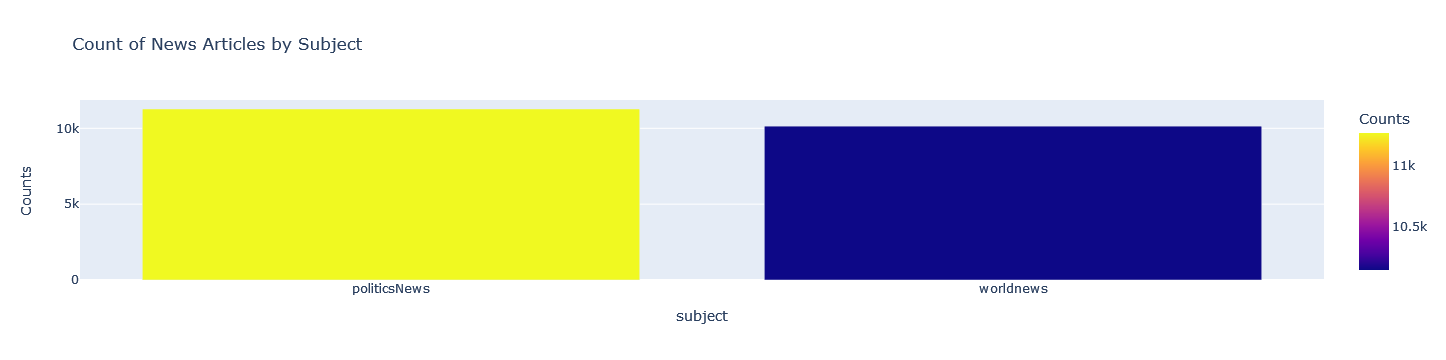

<Figure size 640x480 with 0 Axes>

In [13]:
plt.clf()
sub_check=real_news.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

Merging real and fake news dataframes.

In [14]:
merged_data = pd.concat([real_news,fake_news],axis=0)
merged_data.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  category  
0  December 31, 2017          1  
1  December 29, 2017          1  
2  December 31, 2017          1  
3  December 30, 2017          1  
4  December 29, 2017          1

In [15]:
#combined_df = merged_data.drop(["title","subject","date"],axis=1)
combined_df = merged_data.drop(["subject","date"],axis=1)
combined_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text  category  
0  WASHINGTON (Reuters) - The head of a conservat...         1  
1  WASHINGTON (Reuters) - Transgender people will...         1  
2  WASHINGTON (Reuters) - The special counsel inv...         1  
3  WASHINGTON (Reuters) - Trump campaign adviser ...         1  
4  SEATTLE/WASHINGTON (Reuters) - President Donal...         1

Real news word count in text and title

### Data Cleaning and analysis

In [16]:
def remove_un(data):
    data = data.lower()
    data = re.sub('\[.*?\]','',data)
    data = re.sub('\\W',' ',data)
    data = re.sub('https?://\S+|www.\S+','',data)
    data = re.sub('<.*?>+','',data)
    data = re.sub('[%s]'%re.escape(string.punctuation),'',data)
    data = re.sub('\n','',data)
    data = re.sub('\w*\d\w','',data)
    return data

In [17]:
combined_df['text']= combined_df['text'].apply(remove_un)

In [18]:
combined_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text  category  
0  washington  reuters    the head of a conservat...         1  
1  washington  reuters    transgender people will...         1  
2  washington  reuters    the special counsel inv...         1  
3  washington  reuters    trump campaign adviser ...         1  
4  seattle washington  reuters    president donal...         1

<Figure size 640x480 with 0 Axes>

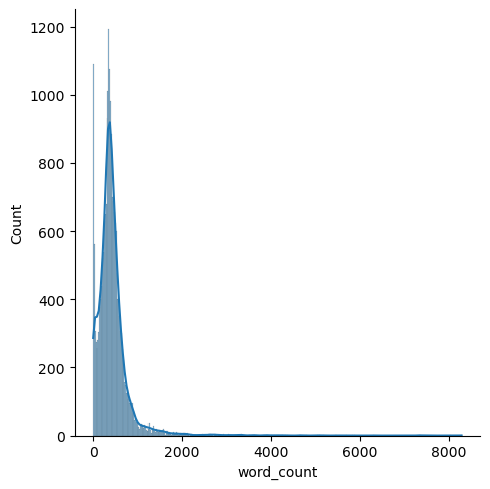

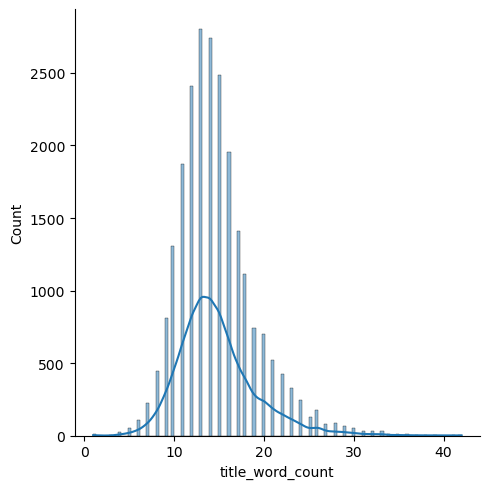

In [19]:
#Real
plt.clf()
combined_df['word_count'] = [len(s.split()) for s in combined_df['text']]
combined_df['title_word_count'] = [len(t.split()) for t in merged_data['title']]

sns.displot(combined_df['word_count'][combined_df['category'] == 0], kde=True, rug=False)
sns.displot(combined_df['title_word_count'][combined_df['category'] == 0], kde=True, rug=False)

plt.show()

Fake news word count in text and title

<Figure size 640x480 with 0 Axes>

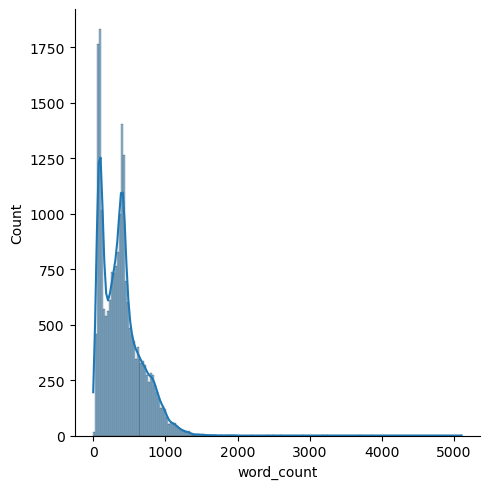

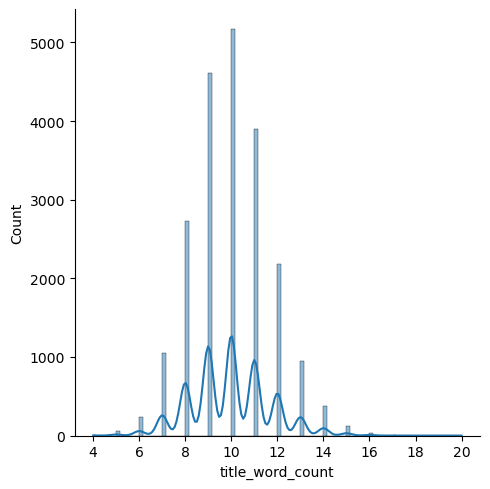

In [20]:
#Fake
plt.clf()
sns.displot(combined_df['word_count'][combined_df['category'] == 1], kde=True, rug=False)
sns.displot(combined_df['title_word_count'][combined_df['category'] == 1], kde=True, rug=False)
plt.show()

Wordcloud for news text most used words

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

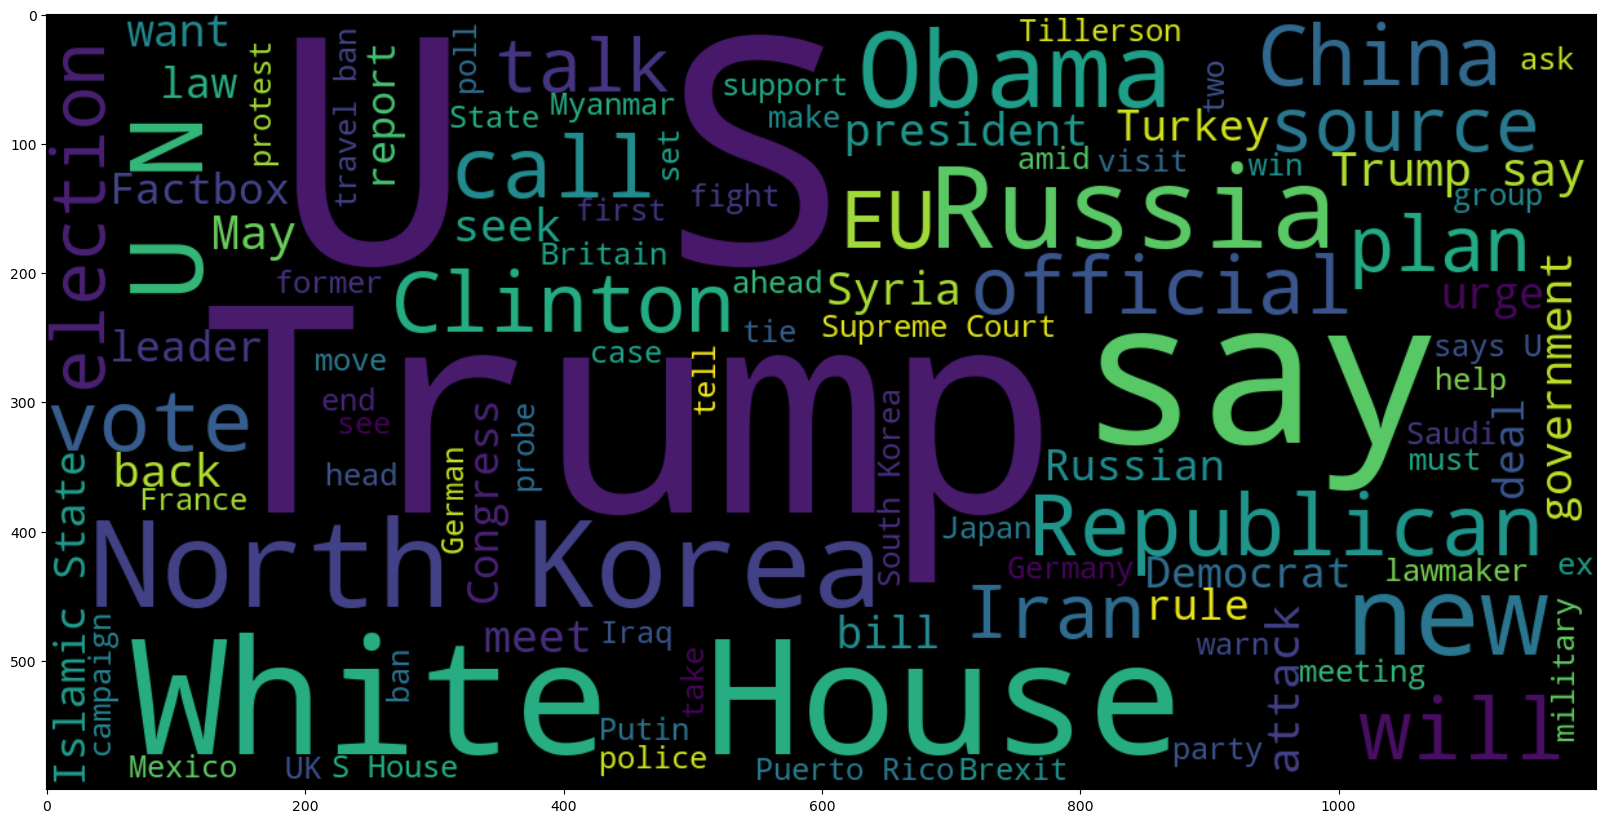

In [22]:
# Title word cloud
plt.clf()
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1200 , height = 600).generate(" ".join(combined_df['title'][combined_df['category'] == 1]))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

<Figure size 640x480 with 0 Axes>

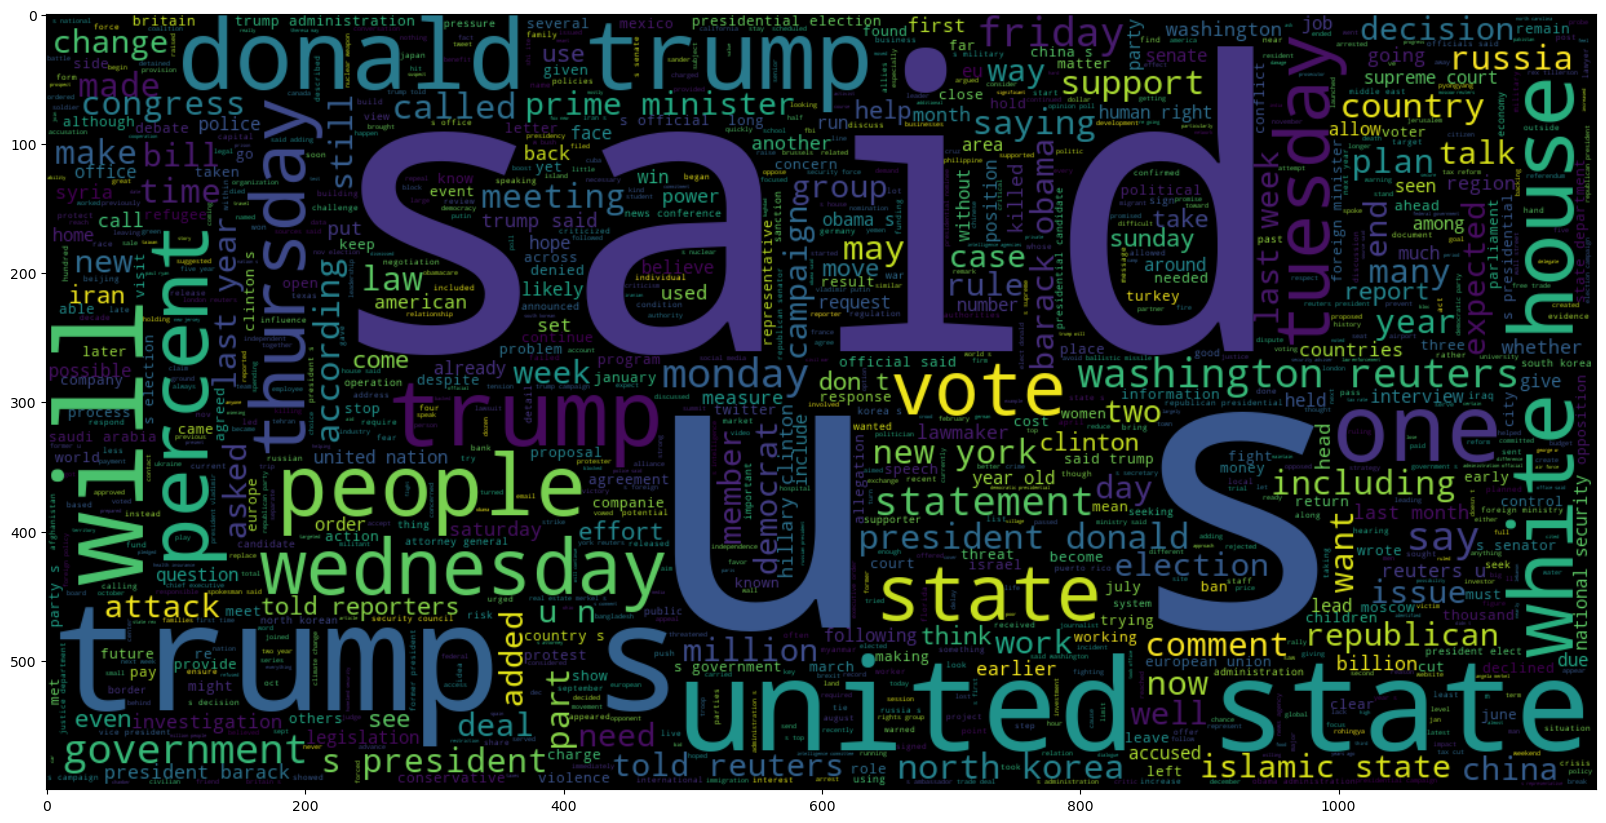

In [23]:
# Text word cloud
plt.clf()
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1200 , height = 600).generate(" ".join(combined_df['text'][combined_df['category'] == 1]))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

<Figure size 640x480 with 0 Axes>

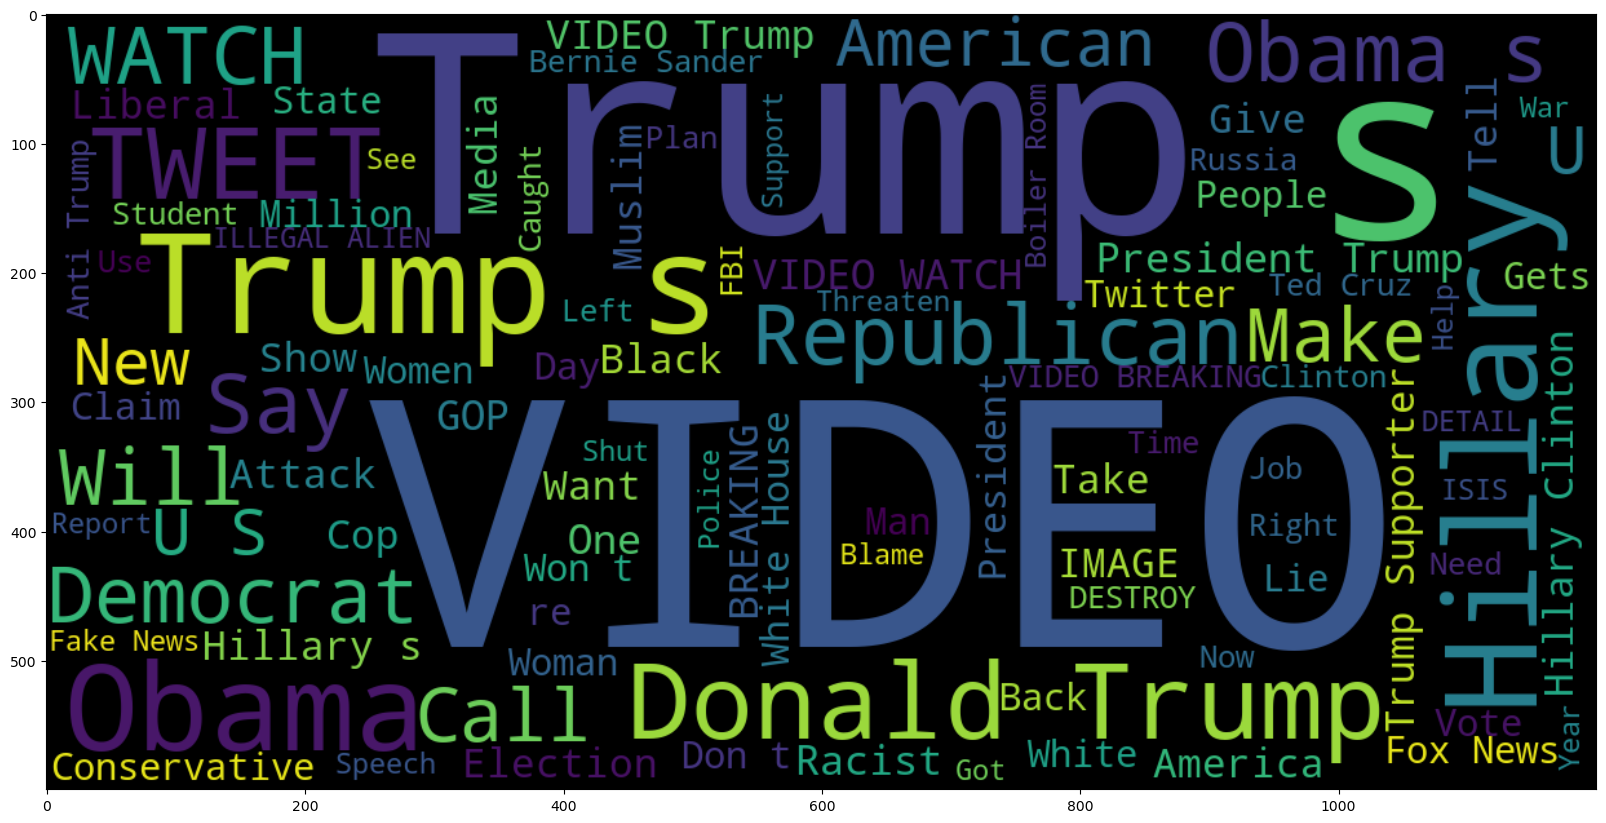

In [24]:
# Title word cloud for fake news
plt.clf()
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1200 , height = 600).generate(" ".join(combined_df['title'][combined_df['category'] == 0]))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

<Figure size 640x480 with 0 Axes>

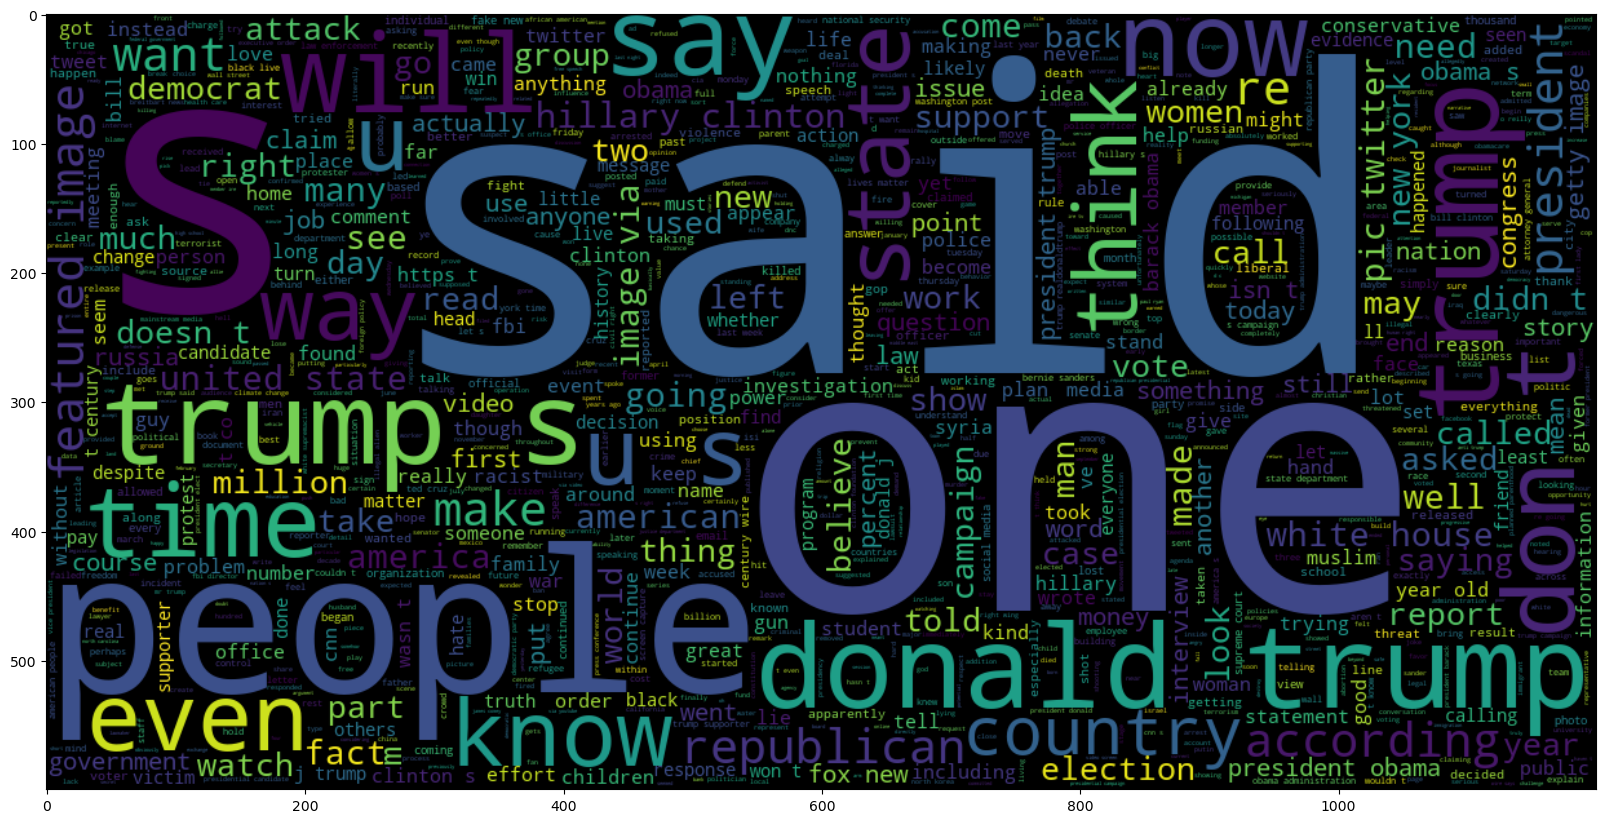

In [25]:
# Text word cloud for fake news
plt.clf()
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1200 , height = 600).generate(" ".join(combined_df['text'][combined_df['category'] == 0]))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [26]:
features = combined_df['text']
targets = combined_df['category']

x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [27]:
def normalize(data):
    normalized = []
    for i in data:
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

x_train = normalize(x_train)
x_test = normalize(x_test)

In [28]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

Convert text to vectors (classifier takes only numerical data)

In [29]:
# tokenize the text into vectors 
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [30]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=256)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=256)

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(x_train,y_train)
LR.score(x_test,y_test)

0.6012700534759359

In [70]:
pred_LR = LR.predict(x_test)
binary_predictions = list()
for i in pred_LR:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
        
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.6012700534759359
Precision on testing set: 0.548081368469718
Recall on testing set: 0.5934918648310388


### Decision Tree Classifier

In [71]:
from sklearn.tree import DecisionTreeClassifier

DT  = DecisionTreeClassifier()
DT.fit(x_train,y_train)
DT.score(x_test,y_test)

0.8905971479500892

In [72]:
pred_DT = DT.predict(x_test)
binary_predictions = list()
for i in pred_DT:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
        
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8905971479500892
Precision on testing set: 0.8610725843735553
Recall on testing set: 0.9072089624939114


### Random Forest Classifier

In [73]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(x_train,y_train)
RFC.score(x_test,y_test)

0.9079768270944741

In [74]:
pred_RFC = RFC.predict(x_test)
binary_predictions = list()
for i in pred_RFC:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
        
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9079768270944741
Precision on testing set: 0.9054553860379103
Recall on testing set: 0.9037840332256576


# Bulding Recurrent Neural Networks (RNNs)

What is an RNN?

A recurrent neural network is a neural network that is specialized for processing a sequence of data x(t)= x(1), . . . , x(τ) with the time step index t ranging from 1 to τ. For tasks that involve sequential inputs, such as speech and language, it is often better to use RNNs. In a NLP problem, if you want to predict the next word in a sentence it is important to know the words before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far.

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We are going to use early stop, which stops when the validation loss no longer improve.

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/5
1077/1077 [==============================] - 288s 261ms/step - loss: 0.2498 - accuracy: 0.8506 - val_loss: 0.0711 - val_accuracy: 0.9783
Epoch 2/5
1077/1077 [==============================] - 280s 260ms/step - loss: 0.0464 - accuracy: 0.9877 - val_loss: 0.0389 - val_accuracy: 0.9911
Epoch 3/5
1077/1077 [==============================] - 283s 263ms/step - loss: 0.0215 - accuracy: 0.9948 - val_loss: 0.0306 - val_accuracy: 0.9928
Epoch 4/5
1077/1077 [==============================] - 277s 257ms/step - loss: 0.0095 - accuracy: 0.9981 - val_loss: 0.0290 - val_accuracy: 0.9936
Epoch 5/5
1077/1077 [==============================] - 253s 235ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.0309 - val_accuracy: 0.9933


Visualize model training data

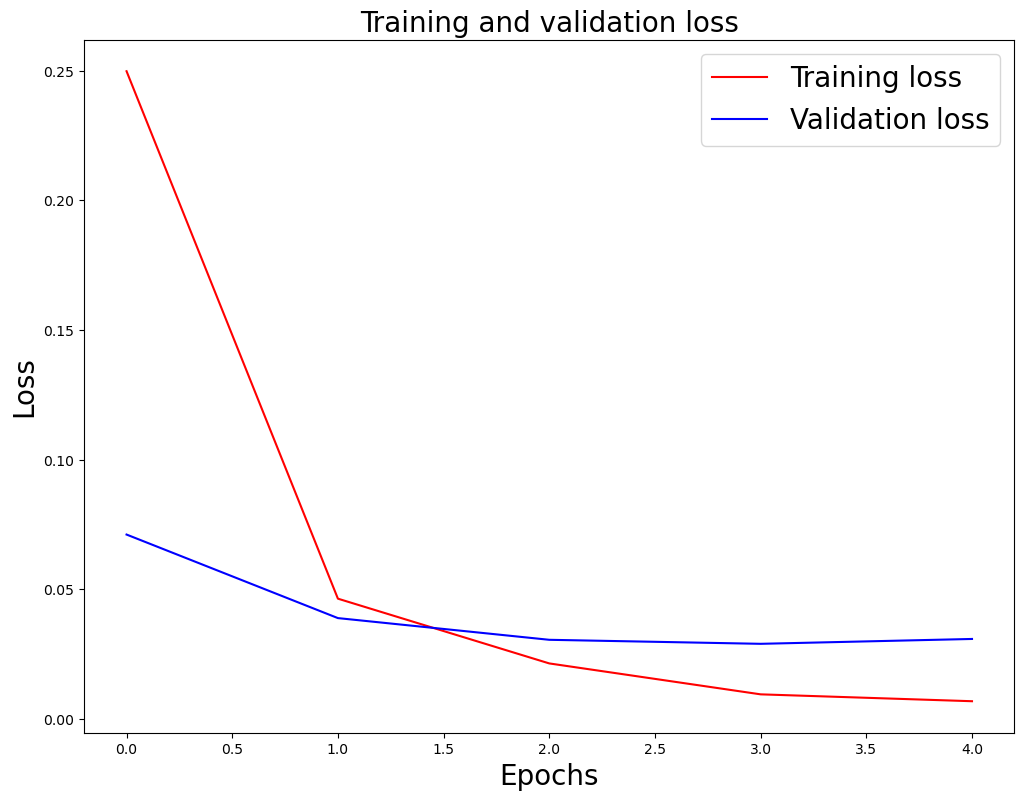

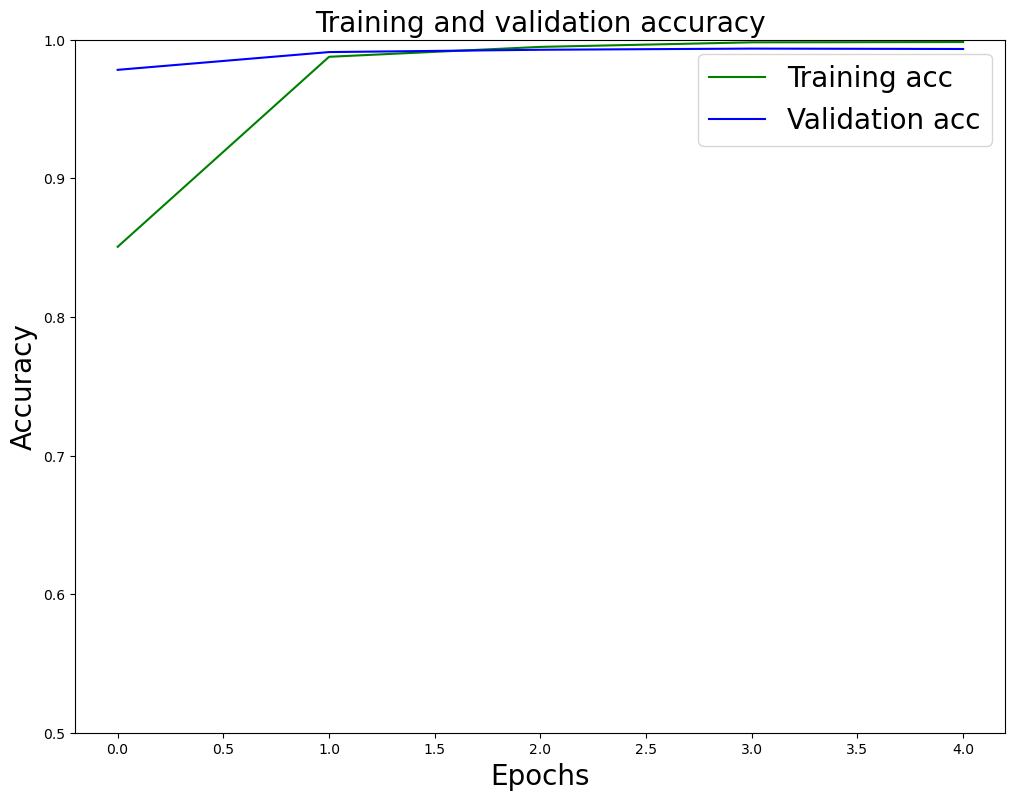

In [33]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set

In [34]:
model.evaluate(x_test, y_test)

281/281 [==============================] - 22s 78ms/step - loss: 0.0385 - accuracy: 0.9892


[0.038532499223947525, 0.9891933798789978]

In [35]:
pred = model.predict(x_test)
binary_predictions = list()
for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

281/281 [==============================] - 23s 77ms/step


In [75]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9079768270944741
Precision on testing set: 0.9054553860379103
Recall on testing set: 0.9037840332256576


### Confusion matrix

<Figure size 640x480 with 0 Axes>

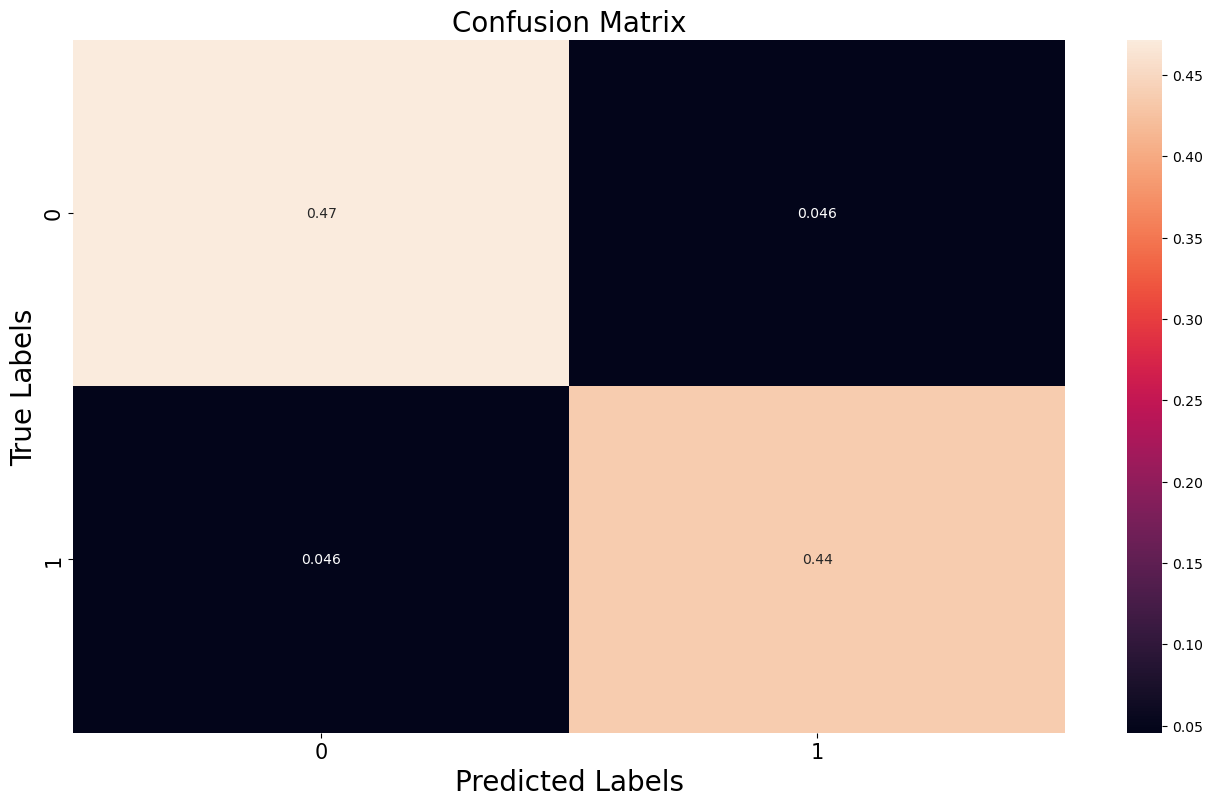

In [76]:
plt.clf()
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
plt.show()

### Vectorization

In [77]:
X_train, X_test, y_train, y_test = train_test_split(combined_df.text, combined_df.category, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5,solver='lbfgs', max_iter=1000)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9953307915685985


<Figure size 640x480 with 0 Axes>

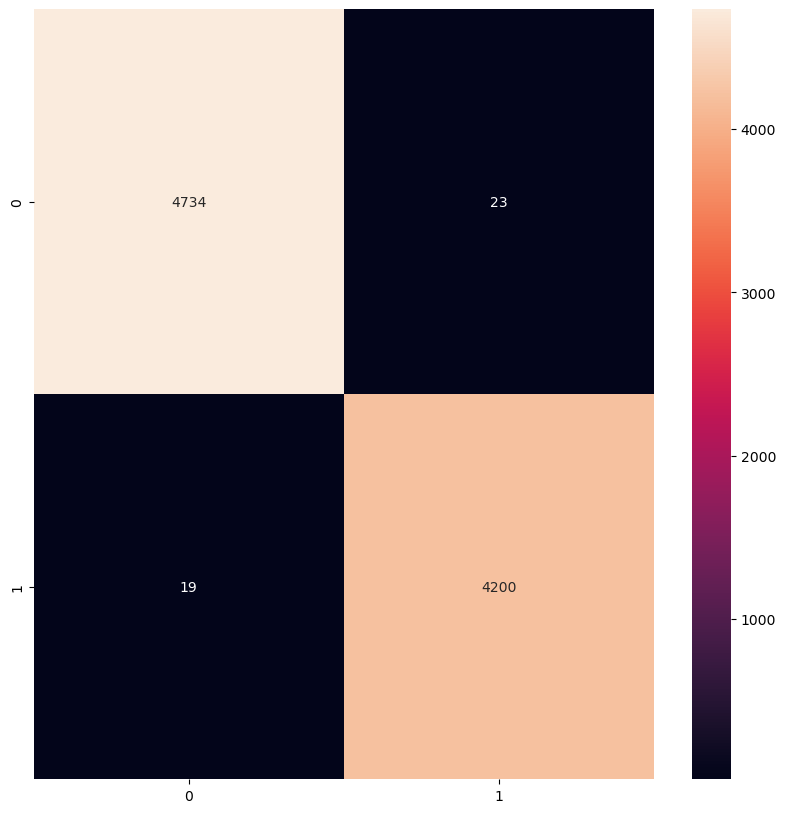

In [78]:
plt.clf()
prediction = list()
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')
plt.show()

# Testing prediction based on news title.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(combined_df.title, combined_df.category, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5,solver='lbfgs', max_iter=1000)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9651237883339348


<Figure size 640x480 with 0 Axes>

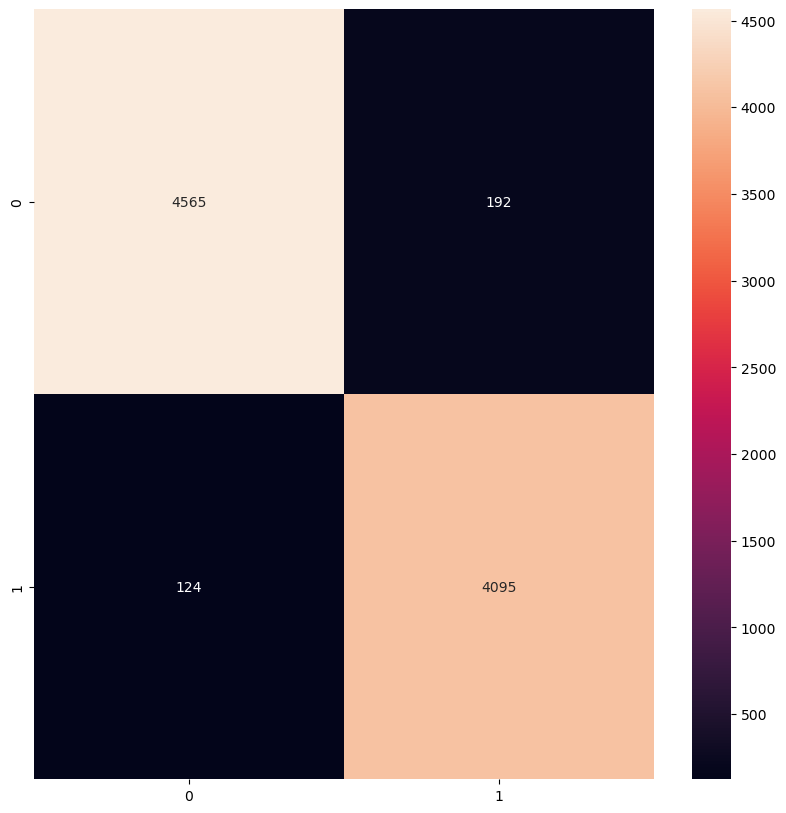

In [82]:
plt.clf()
prediction = list()
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')
plt.show()

## Conclusion 

After testing the accuracy of models based on news article text and title, we can see that the more words we have ther better the model accuracy is.
Because of that the accuracy of models based on the article text is far better than based on the title.

We have successfully attained the goal of categorizing news and determining whether it is true or false.
However, I would like to draw attention to the following points:
    'The news cannot be accurately predicted based solely on the headline.
    
    When we took into account the article text for the news, a far better idea was obtained.
    
    The accuracy rates increased dramatically from 96% to 99+%.
    
    We have been able to get the maximum percentages of correctness by taking into account both the title and the context.'

I would like to add a few things to the data:

    'The model might perform better with a bigger amount of input, so we'll consider along those lines and work to further improve it. '
